# Assignment 3

> Group Members: Alexandros Gilch, Paul Grass, Tim Mensinger, Philipp Schirmer

## Question I: Crises

In this notebook our group aims to answer the question whether financial crises can be predicted using past data. Again, the notebook is structured as follows: We first implement our functions in the section **code**. This includes functions necessary to fit the logistic regression model and plotting functions. In the subsequent **results** section we then answer questions *i. - iii*.

Once more we remark that the code section may be skipped by everyone uninterested in the implementation, and that this notebook is best enjoyed [online](https://nbviewer.jupyter.org/github/timmens/macro_problems/blob/main/assignment3.ipynb?flush_cache=False).  

In [43]:
import warnings
import patsy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve as sklearn_plot_roc_curve
from sklearn.metrics import roc_auc_score

from statsmodels.discrete.discrete_model import Logit

from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

sns.set_style("whitegrid")

## Code

In [10]:
def read_and_clean_data() -> pd.DataFrame:
    """Read data, set index and rename tloans to credit."""
    # read
    df = pd.read_stata("data/JSTdatasetR5.dta")

    # simple clean
    df = df.set_index(["ifs", "year"])
    df = df.rename(columns={"tloans": "credit"})

    # generate additional regressors
    for col in ["credit", "money", "hpnom"]:
        df = df.assign(**{f"real_{col}": df[col] / df.cpi})
        df = df.assign(**{f"diff_log_real_{col}": np.log(df[f"real_{col}"]).diff(1)})

    return df

In [11]:
def compute_aggregate_credit_and_money(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate credit and money for each year."""
    df_agg = df.groupby("year")[["credit", "money", "gdp"]].sum()
    df_agg = df_agg.assign(
        **{f"{var}2gdp": df_agg[var] / df_agg.gdp for var in ("credit", "money")}
    )
    df_agg = df_agg.reset_index()
    return df_agg


def plot_aggregate_credit_and_money(df_agg: pd.DataFrame) -> None:
    """Plots time-series of aggregate credit and money."""
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)

    sns.lineplot(x="year", y="credit2gdp", data=df_agg, ax=ax, label="Credit to GDP")
    sns.lineplot(x="year", y="money2gdp", data=df_agg, ax=ax, label="Money to GDP")

    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set(ylabel="", xlabel="Year")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.legend(fontsize=14)
    return None

In [12]:
def _create_formula_with_lags(var_name: str, n_lags: int) -> str:
    """Creates formula str of var_name with n_lags."""
    covariates = [f"{var_name}.shift({i})" for i in range(1, n_lags + 1)]
    formula = " + ".join(covariates)
    return formula

In [13]:
def extract_info_from_statsmodels_fit(model, df):
    # test for joint signifance
    select_relevant_params = model.params.index.str.startswith("diff_log_real_credit")
    r_matrix = np.eye(len(select_relevant_params))[-select_relevant_params.sum() :]
    f_test_pvalue = float(model.f_test(r_matrix).pvalue)

    # info on diff_log_real_credit estimates
    params = pd.DataFrame(
        {
            "coef": model.params[select_relevant_params],
            "se": model.bse[select_relevant_params],
            "pvalue": model.pvalues[select_relevant_params],
        }
    )
    params = params.set_axis(range(1, len(params) + 1))
    params = params.rename_axis("Lag")

    # info on fixed effect estimates
    ifs2country = (
        df.reset_index().groupby("ifs")["country"].first().to_frame().reset_index()
    )
    select_fixed_effects = model.params.index.str.startswith("C(ifs)")

    fixed_effects = pd.DataFrame(
        {
            "coef": model.params[select_fixed_effects],
            "se": model.bse[select_fixed_effects],
            "pvalue": model.pvalues[select_fixed_effects],
            "ifs": df.index.get_level_values("ifs").unique().sort_values()[1:],
        }
    )

    fixed_effects = fixed_effects.merge(ifs2country, on="ifs")
    fixed_effects = fixed_effects.drop("ifs", axis=1).set_index("country")

    return f_test_pvalue, params, fixed_effects

In [14]:
def plot_roc_curve(model, X_train, y_train, X_test, y_test, title=None, ax=None):
    """Plots ROC curve."""
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(14, 7)

    sklearn_plot_roc_curve(model, X_train, y_train, ax=ax, label="In-Sample")
    sklearn_plot_roc_curve(model, X_test, y_test, ax=ax, label="Out-of-Sample")
    ax.axline([0, 0], [1, 1], color="gray", label="Coin Flip")
    
    if 

    auc_in = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    auc_out = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    suffix = f"AUC-IN = {auc_in:.3f}; AUC-OUT = {auc_out:.3f}"
    title = suffix if title is None else title + "; " + suffix
    ax.set_title(title, fontsize=16)

    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.legend(fontsize=14)
    return None

In [15]:
def _create_model_data(formula, df, with_predictors=None):
    """Create model data from data frame.
    
    Given a patsy-style formula (similar to an R-formula), a data frame and possibly a list of
    further predictors, create the design matrix X and the outcome vector y.
    
    Args:
        formula (str): patsy style formula object.
        df (pandas.DataFrame): The data set.
        with_predictors (Union[str, List[str]]): Additional predictors to consider. Default None.
        
    Returns:
        Tuple[pd.Series, pd.DataFrame]:
            y: The outcome series.
            X: The design matrix.
    
    """
    df = df.copy().reset_index()

    with_predictors = with_predictors or []
    with_predictors = (
        with_predictors if isinstance(with_predictors, list) else [with_predictors]
    )
    if len(with_predictors) > 0:
        formula += " + " + " + ".join(with_predictors)

    y, X = patsy.dmatrices(formula, df, return_type="dataframe")
    y = y["crisisJST"]

    return y, X

In [16]:
def _create_test_train_data(df, formula, with_predictors=None):
    df_train = df.query("year <= 1994")
    df_test = df.query("year > 1994")

    y_train, X_train = _create_model_data(formula, df_train, with_predictors)
    y_test, X_test = _create_model_data(formula, df_test, with_predictors)

    data = {"y_train": y_train, "y_test": y_test, "X_train": X_train, "X_test": X_test}
    return data

In [17]:
def fit_logit(y_train=None, X_train=None, data=None, backend="sklearn", max_iter=250):
    if data is not None:
        y_train = data["y_train"]
        X_train = data["X_train"]

    if backend == "statsmodels":
        model = Logit(y_train, X_train).fit(disp=False)
    elif backend == "sklearn":
        model = LogisticRegression(
            fit_intercept=False, penalty="l2", max_iter=max_iter
        ).fit(X_train, y_train)
    else:
        raise ValueError("'backend' must be eiter sklearn or statsmodels.")

    return model

In [49]:
def plot_predictor_comparison(fit_func, **kwargs):
    
    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(24, 14)

    mapper = {
        "Baseline": "Baseline",
        "money": "Money",
        "hpnom": "Asset Prices",
        "ca": "Current Account",
    }

    for ax, var in zip(axes.flatten(), ["Baseline", "money", "hpnom", "ca"]):
        if var == "Baseline":
            with_predictors = None
        else:
            with_predictors = [f"{var}.shift({l})" for l in range(1, 7)]
        data = _create_test_train_data(df, formula, with_predictors)
        model = fit_func(data=data, **kwargs)
        plot_roc_curve(model, **data, title=mapper[var], ax=ax)
    
    return None

#### Neural Networks

In [18]:
def _get_build_model_func(input_dim, layers):
    """Create a function to build a neural network model.
    
    The ``build_model`` function is needed by the Keras model to build the neural
    network. Here we create this function dynamically.
    Example for layers. ``layers = "54-81-54"`` means that the first hidden layer has
    54 nodes, the second hidden layer has 81 nodes, the third hidden layer has again 54
    nodes and implicitly the output layer has one node.
    
    Args:
        input_dim (int): Number of features.
        layers (str): String describing the number of nodes per hidden layer.
        
    Returns:
        build_model (function): Function to build a neural net model.
        
    """
    layers = [int(n) for n in layers.split("-")]

    def build_model():
        model = Sequential()
        model.add(Dense(units=layers[0], activation="relu", input_dim=input_dim))
        for u in layers[1:]:
            model.add(Dense(units=u, activation="relu"))
        model.add(Dense(units=1, activation="sigmoid"))
        model.compile(optimizer="adam", loss="binary_crossentropy")
        return model

    return build_model

In [38]:
def fit_neural_network(y_train=None, X_train=None, data=None, layers=None, n_epochs=100, n_batch_size=20):
    """Fit a neural network regressor.
    
    Args:
        ....
        layers (str): str specifying the number of hidden layers and hidden nodes in the
            neural network. Example: "100-100-100".
        n_epochs (int): Number of epochs used for model fitting.
        n_batch_size (int): Batch size used for model fitting.
        
    Returns:
        nnet: The fitted neural network.
            
    """
    if data is not None:
        y_train = data["y_train"]
        X_train = data["X_train"]
        
    build_model = _get_build_model_func(input_dim=X_train.shape[1], layers=layers)

    nnet = KerasClassifier(
        build_fn=build_model, batch_size=n_batch_size, epochs=n_epochs
    )
    nnet._estimator_type = "classifier"
    nnet.fit(X_train, y_train, verbose=False)
    return nnet

## Results

### i.

In [20]:
df = read_and_clean_data()

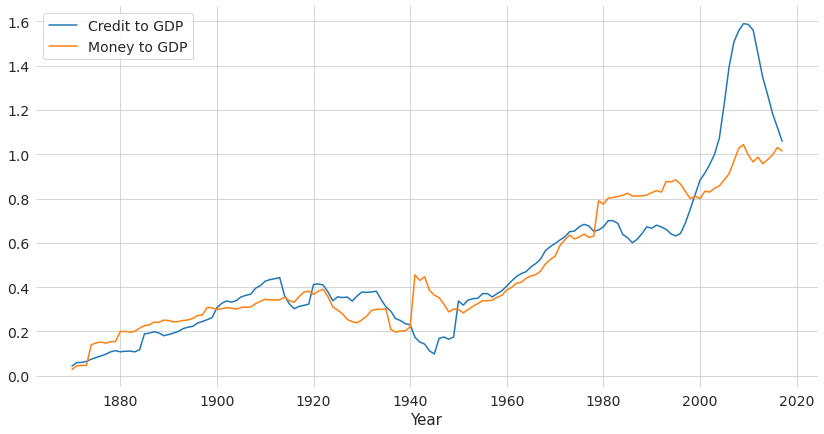

In [21]:
df_agg = compute_aggregate_credit_and_money(df)

plot_aggregate_credit_and_money(df_agg)

### ii.

Below we fit a logit fixed effects model with 5 lags of log changes in real credit as an additional predictor. To answer **ii.1**, the p-value of an f-test for joint significance of the five lags of real credit growth is given below as ~1.5e-5. That is we can reject the null hypothesis of no effect with great confidence. We then print that coefficient estimates, standard errors and standard pvalues (i.e. non corrected for multiple-testing problems) for the coefficients of the five lags of real credit growth. Below that we print the fixed effect estimates. Since we include an intercept in the regression the fixed effects are relative to the country left out, which in our case is USA.

In [22]:
formula = "crisisJST ~ C(ifs) + " + _create_formula_with_lags("diff_log_real_credit", 5)

y, X = _create_model_data(formula, df)

model = fit_logit(y, X, backend="statsmodels")

In [23]:
f_test_pvalue, params, fixed_effects = extract_info_from_statsmodels_fit(model, df)

In [24]:
f_test_pvalue

6.51402668550305e-07

In [25]:
params

,coef,se,pvalue
Lag,,,
1,1.062679,1.246715,3.940014e-01
2,5.542023,1.089714,3.661618e-07
3,-0.241261,0.098925,1.473544e-02
4,0.305101,0.579162,5.983352e-01
5,0.701906,0.927231,4.490549e-01


In [26]:
fixed_effects

,coef,se,pvalue
country,,,
UK,-0.208926,0.684654,0.760248
Belgium,0.330508,0.649003,0.610574
Denmark,0.085535,0.619747,0.890228
France,-0.830577,0.865253,0.337093
Germany,-0.278321,0.667320,0.676626
Italy,0.327526,0.580155,0.572380
Netherlands,-0.841021,0.848713,0.321717
Norway,-0.351245,0.683981,0.607580
Sweden,0.155336,0.619436,0.801992


### iii.: Model Evaluation

#### iii.1

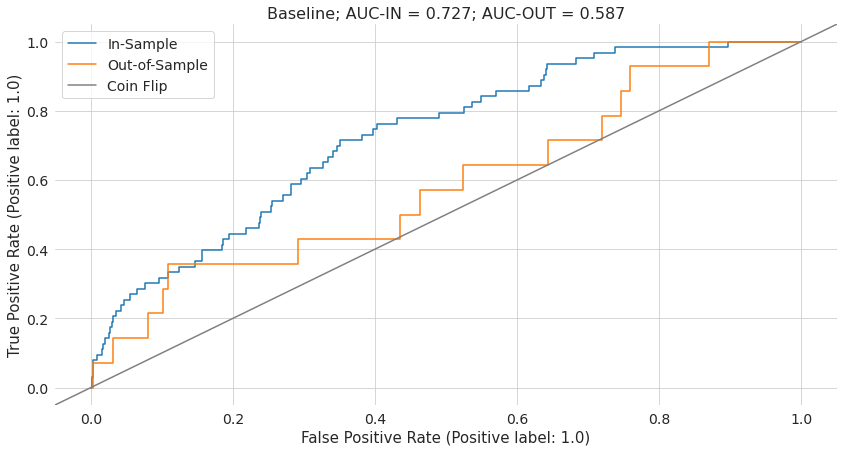

In [27]:
data = _create_test_train_data(df, formula)

model = fit_logit(data=data, backend="sklearn")

baseline_plot = plot_roc_curve(model, **data, title="Baseline")

#### iii.2 and iii.3

We start by plotting the ROC curves for the baseline specification and the additional variables. 

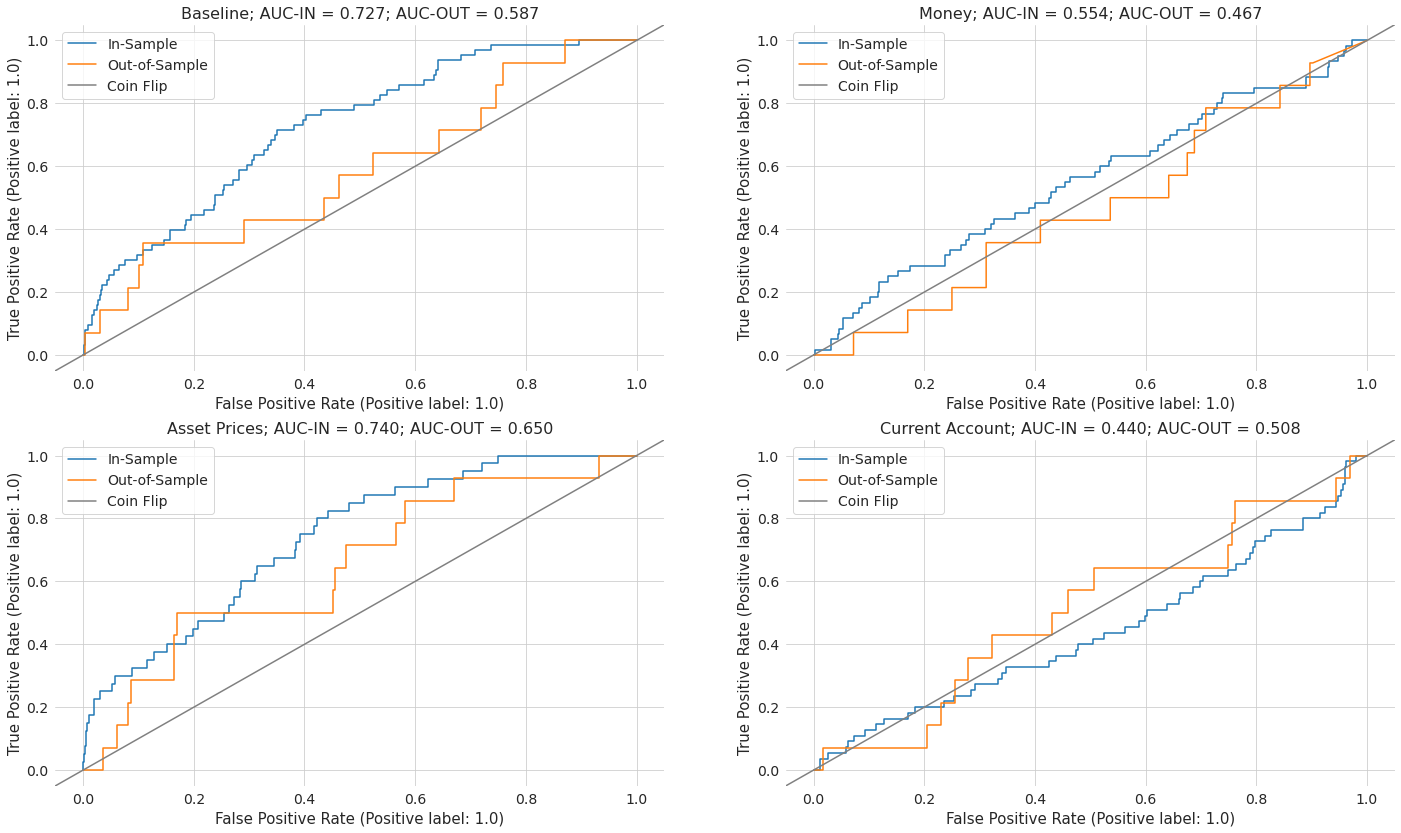

In [50]:
plot_predictor_comparison(fit_logit, backend="sklearn", max_iter=10_000)

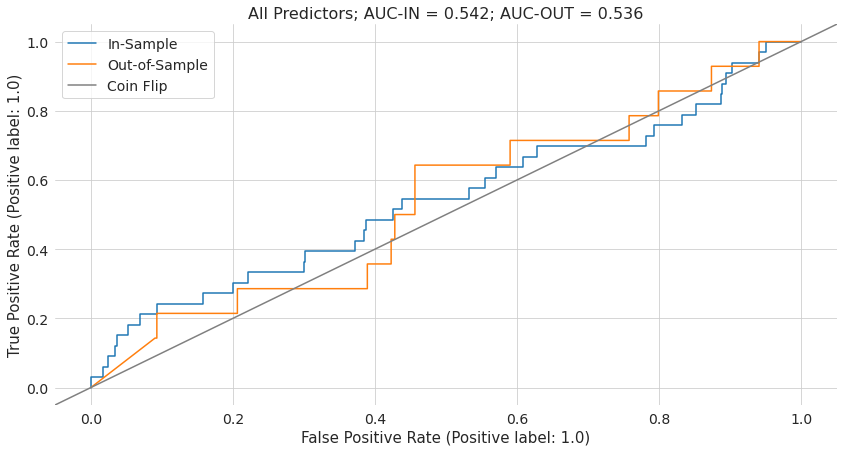

In [29]:
with_predictors = [
    f"{var}.shift({lag})" for var in ("money", "hpnom", "ca") for lag in range(1, 7)
]

data = _create_test_train_data(df, formula, with_predictors=with_predictors)

model = fit_logit(data=data, backend="sklearn", max_iter=10_000)
plot_roc_curve(model, **data, title="All Predictors")

## Neural Networks

In [39]:
model = fit_neural_network(data=data, layers="100-40-20")

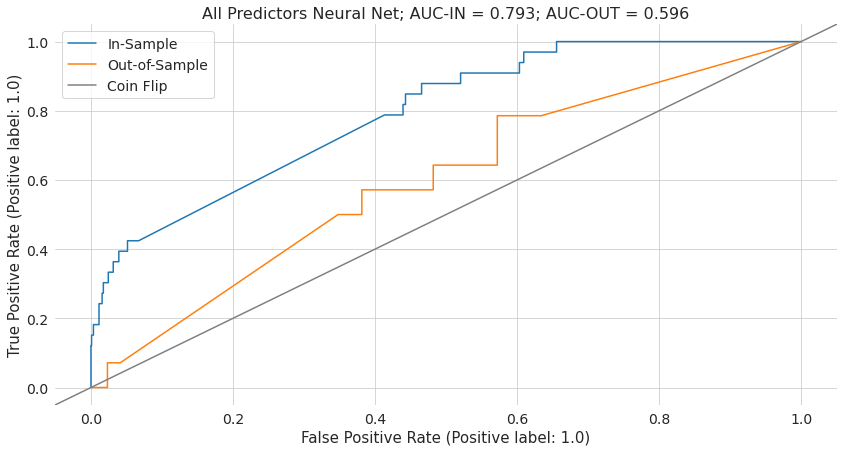

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_roc_curve(model, **data, title="All Predictors Neural Net")

/home/tim/miniconda3/envs/macro/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/tim/miniconda3/envs/macro/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/tim/miniconda3/envs/macro/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/tim/miniconda3/envs/macro/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:4

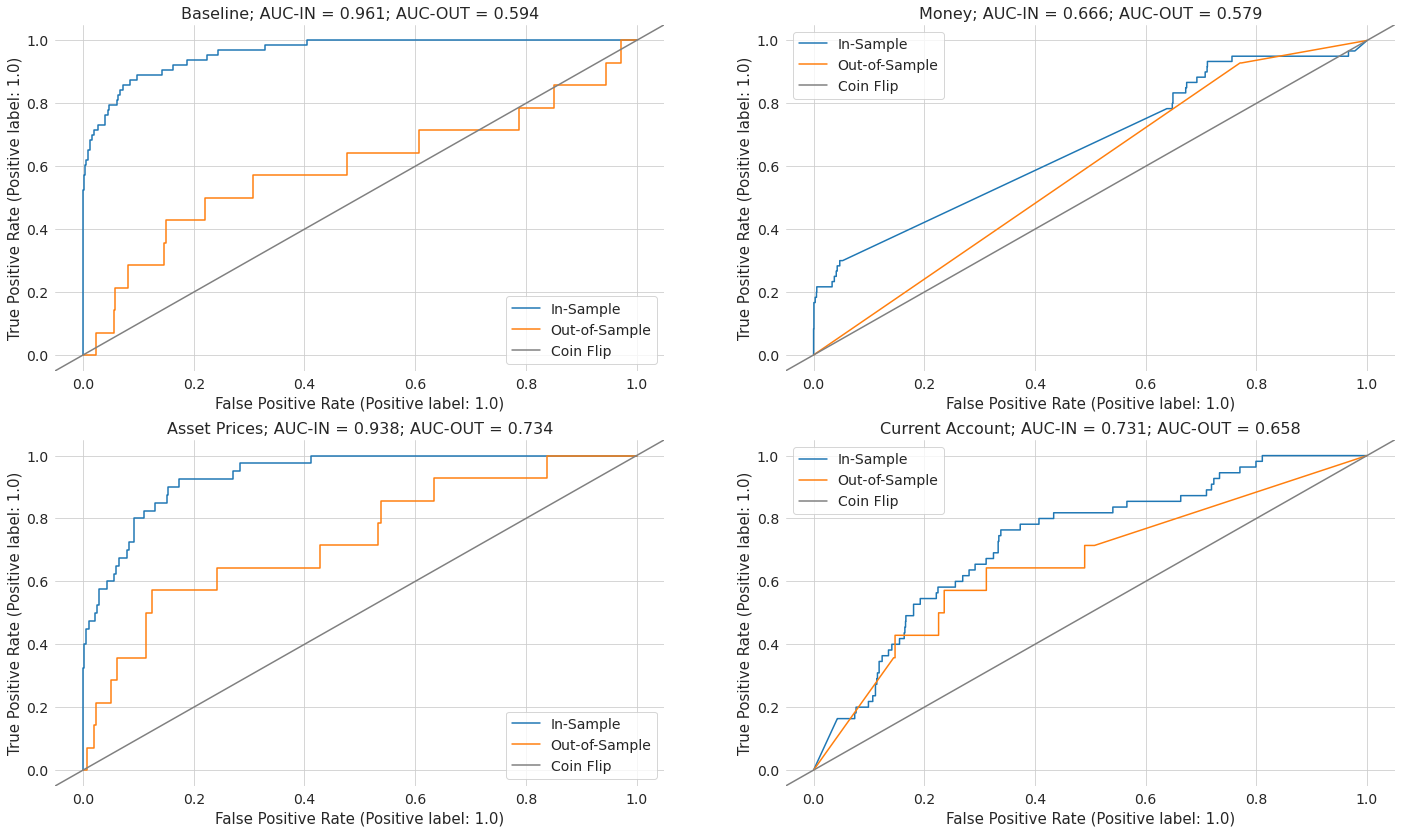

In [52]:
plot_predictor_comparison(fit_neural_network, layers="100-40-20")